# Maintenance Segmentation Client avec K-Means

In [1]:
pip install pandas numpy sqlalchemy scikit-learn matplotlib seaborn yellowbrick

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
import sqlite3
import pandas as pd
import numpy as np

database_path = '/Users/arotanodari/Desktop/COURS/Projet olist ecommerce/olist.db'

conn = sqlite3.connect(database_path)

In [3]:
customers_df = pd.read_sql_query("SELECT * FROM customers", conn)
orders_df = pd.read_sql_query("SELECT * FROM orders", conn)
order_items_df = pd.read_sql_query("SELECT * FROM order_items", conn)
payments_df = pd.read_sql_query("SELECT * FROM order_pymts", conn)
reviews_df = pd.read_sql_query("SELECT * FROM order_reviews", conn)

conn.close()

In [4]:
# 1. Première jointure : customers_df et orders_df (FULL OUTER JOIN sur 'customer_id')
order_join = pd.merge(
    customers_df[['customer_unique_id', 'customer_id']],
    orders_df[['customer_id', 'order_id', 'order_purchase_timestamp']],
    on='customer_id',
    how='outer'
)

# 2. Deuxième jointure : order_join et order_items_df (FULL OUTER JOIN sur 'order_id')
order_item_join = pd.merge(
    order_join,
    order_items_df[['order_id', 'order_item_id', 'product_id', 'price', 'freight_value']],
    on='order_id',
    how='outer'
)

# 3. Troisième jointure : order_item_join et order_payments_df (FULL OUTER JOIN sur 'order_id')
order_payment_join = pd.merge(
    order_item_join,
    payments_df[['order_id', 'payment_value']],
    on='order_id',
    how='outer'
)

# 4. Quatrième jointure : order_payment_join et order_reviews_df (FULL OUTER JOIN sur 'order_id')
order_reviews_join = pd.merge(
    order_payment_join,
    reviews_df[['order_id', 'review_id', 'review_score']],
    on='order_id',
    how='outer'
)

# 5. Agrégation des données groupées par 'customer_unique_id'
df = order_reviews_join.groupby('customer_unique_id').agg({
    'order_id': pd.Series.nunique,    # nb_orders distinctes
    'product_id': pd.Series.nunique,  # avg_products distincts
    'payment_value': 'sum',           # sum_payments
    'review_score': 'mean',           # avg_review
    'order_purchase_timestamp': 'max' # last_purchase
}).reset_index()

# 6. Renommer les colonnes pour correspondre à la requête SQL
df.rename(columns={
    'order_id': 'nb_orders',
    'product_id': 'avg_products',
    'payment_value': 'sum_payments',
    'review_score': 'avg_review',
    'order_purchase_timestamp': 'last_purchase'
}, inplace=True)

# 7. Arrondir 'sum_payments' et 'avg_review' à une décimale
df['sum_payments'] = df['sum_payments'].round(1)
df['avg_review'] = df['avg_review'].round(1)

# 8. S'assurer que 'last_purchase' est au format datetime
df['last_purchase'] = pd.to_datetime(df['last_purchase'])

# Résultat final
df


,customer_unique_id,nb_orders,avg_products,sum_payments,avg_review,last_purchase
0,0000366f3b9a7992bf8c76cfdf3221e2,1,1,141.9,5.0,2018-05-10 10:56:27
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,1,27.2,4.0,2018-05-07 11:11:27
2,0000f46a3911fa3c0805444483337064,1,1,86.2,3.0,2017-03-10 21:05:03
3,0000f6ccb0745a6a4b88665a16c9f078,1,1,43.6,4.0,2017-10-12 20:29:41
4,0004aac84e0df4da2b147fca70cf8255,1,1,196.9,5.0,2017-11-14 19:45:42
...,...,...,...,...,...,...
96091,fffcf5a5ff07b0908bd4e2dbc735a684,1,2,4134.8,5.0,2017-06-08 21:00:36
96092,fffea47cd6d3cc0a88bd621562a9d061,1,1,84.6,4.0,2017-12-10 20:07:56
96093,ffff371b4d645b6ecea244b27531430a,1,1,112.5,5.0,2017-02-07 15:49:16
96094,ffff5962728ec6157033ef9805bacc48,1,1,133.7,5.0,2018-05-02 15:17:41


In [5]:
# Assurez-vous que last_purchase est en datetime
df['last_purchase'] = pd.to_datetime(df['last_purchase'])

# Calcul de la variable "recency" en jours par rapport à une date de référence
date_reference = pd.to_datetime("2018-10-17")  
df['recency'] = (date_reference - df['last_purchase']).dt.days

# Sélection des variables RFM
features = ['recency', 'nb_orders', 'sum_payments']
rfm = df[['customer_unique_id', 'recency', 'nb_orders', 'sum_payments']].copy()

# Vérification des colonnes disponibles
print("Colonnes du DataFrame rfm:", rfm.columns)


Colonnes du DataFrame rfm: Index(['customer_unique_id', 'recency', 'nb_orders', 'sum_payments'], dtype='object')


In [6]:
from sklearn.preprocessing import StandardScaler

# Sélection des features pour le clustering
features = ['recency', 'nb_orders', 'sum_payments']
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[features])


In [7]:
from sklearn.cluster import KMeans

# Définition du nombre de clusters, ici 4 par exemple
n_clusters = 4
km = KMeans(n_clusters=n_clusters, random_state=42)
rfm['cluster'] = km.fit_predict(rfm_scaled)

# Visualisation du nombre de clients par cluster
print(rfm.groupby('cluster').size())


cluster
0    53290
1    39782
2       32
3     2992
dtype: int64


In [8]:
import pandas as pd
import numpy as np
from datetime import datetime

# Calcul de la variable 'recency' en jours par rapport à une date de référence 
date_reference = pd.to_datetime("2018-10-17")  
df['recency'] = (date_reference - df['last_purchase']).dt.days


rfm = df[['customer_unique_id', 'recency', 'nb_orders', 'sum_payments']].copy()

# Affichage des 5 premières lignes
print(rfm.head())


                 customer_unique_id  recency  nb_orders  sum_payments
0  0000366f3b9a7992bf8c76cfdf3221e2      159          1         141.9
1  0000b849f77a49e4a4ce2b2a4ca5be3f      162          1          27.2
2  0000f46a3911fa3c0805444483337064      585          1          86.2
3  0000f6ccb0745a6a4b88665a16c9f078      369          1          43.6
4  0004aac84e0df4da2b147fca70cf8255      336          1         196.9


In [9]:
# Récupération des indicateurs + last_purchase
rfm = df[['customer_unique_id', 'recency', 'nb_orders', 'sum_payments', 'last_purchase']].copy()

# Affichage
rfm.head()


,customer_unique_id,recency,nb_orders,sum_payments,last_purchase
0,0000366f3b9a7992bf8c76cfdf3221e2,159,1,141.9,2018-05-10 10:56:27
1,0000b849f77a49e4a4ce2b2a4ca5be3f,162,1,27.2,2018-05-07 11:11:27
2,0000f46a3911fa3c0805444483337064,585,1,86.2,2017-03-10 21:05:03
3,0000f6ccb0745a6a4b88665a16c9f078,369,1,43.6,2017-10-12 20:29:41
4,0004aac84e0df4da2b147fca70cf8255,336,1,196.9,2017-11-14 19:45:42


Date: 2017-01-18 - ARI: 1.000
Date: 2017-02-05 - ARI: 0.965
Date: 2017-02-22 - ARI: 0.975
Date: 2017-03-12 - ARI: 0.976
Date: 2017-03-29 - ARI: 0.969
Date: 2017-04-16 - ARI: 0.951
Date: 2017-05-03 - ARI: 0.157
Date: 2017-05-21 - ARI: 0.120
Date: 2017-06-07 - ARI: 0.091
Date: 2017-06-25 - ARI: 0.127
Date: 2017-07-12 - ARI: 0.081
Date: 2017-07-30 - ARI: 0.081


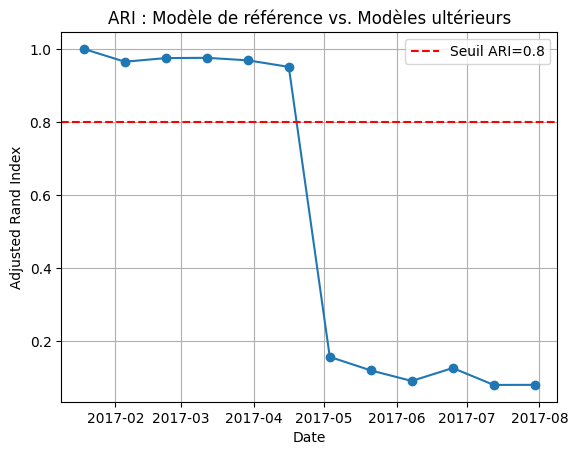

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import adjusted_rand_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from datetime import datetime, timedelta

# --- Paramètres temporels ---
start_date = pd.to_datetime("2017-01-01")
end_date = pd.to_datetime("2017-07-31")
delta = timedelta(weeks=2.5)
dates = pd.date_range(start_date, end_date, freq=delta)

# --- Fenêtre initiale (t=0) ---
df_ref = rfm[rfm['last_purchase'] <= (start_date + delta)]
if df_ref.empty:
    raise ValueError("Aucune donnée dans la fenêtre initiale.")

features = ['recency', 'nb_orders', 'sum_payments']
X_ref = df_ref[features]

# --- Normalisation et K-Means de référence ---
scaler_ref = StandardScaler().fit(X_ref)
X_ref_scaled = scaler_ref.transform(X_ref)

kmeans_ref = KMeans(n_clusters=4, random_state=42)
labels_ref = kmeans_ref.fit_predict(X_ref_scaled)

# --- Calcul de l'ARI sur les fenêtres suivantes ---
ari_scores = []

for current_date in dates[1:]:
    df_t = rfm[rfm['last_purchase'] <= current_date]
    if df_t.empty:
        continue
    
    X_t_scaled = scaler_ref.transform(df_t[features])
    kmeans_t = KMeans(n_clusters=4, random_state=42)
    labels_t = kmeans_t.fit_predict(X_t_scaled)
    
    # Labels prédits par le modèle de référence
    pred_ref = kmeans_ref.predict(X_t_scaled)
    
    # ARI entre modèle de référence et nouveau modèle
    ari = adjusted_rand_score(pred_ref, labels_t)
    ari_scores.append((current_date, ari))
    print(f"Date: {current_date.date()} - ARI: {ari:.3f}")

# --- Visualisation ---
ari_df = pd.DataFrame(ari_scores, columns=['date', 'ARI'])
plt.plot(ari_df['date'], ari_df['ARI'], marker='o')
plt.axhline(0.8, color='red', linestyle='--', label='Seuil ARI=0.8')
plt.title("ARI : Modèle de référence vs. Modèles ultérieurs")
plt.xlabel("Date")
plt.ylabel("Adjusted Rand Index")
plt.legend()
plt.grid(True)
plt.show()

2017-01-01 - ARI: 1.000
2017-01-18 - ARI: 0.521
2017-02-05 - ARI: 0.321
2017-02-22 - ARI: 0.287
2017-03-12 - ARI: 0.256
2017-03-29 - ARI: 0.102
2017-04-16 - ARI: 0.150
2017-05-03 - ARI: 0.120
2017-05-21 - ARI: 0.088
2017-06-07 - ARI: 0.071
2017-06-25 - ARI: 0.104
2017-07-12 - ARI: 0.108
2017-07-30 - ARI: 0.036


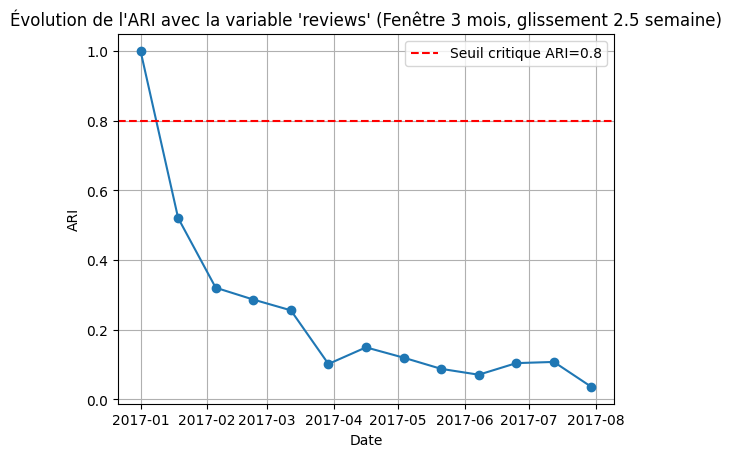

In [13]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

# --- Préparation du DataFrame RFM avec la variable 'reviews' ---
rfm = df[['customer_unique_id', 'last_purchase', 'nb_orders', 
          'sum_payments', 'avg_review']].copy()

# Calcul de la récence
rfm['recency'] = (pd.to_datetime("2025-01-01") - pd.to_datetime(rfm['last_purchase'])).dt.days

# Création de la colonne 'reviews' et remplissage des NaN
rfm['reviews'] = rfm['avg_review'].fillna(rfm['avg_review'].mean())

# --- Paramètres temporels ---
start_date = pd.to_datetime("2017-01-01")
end_date   = pd.to_datetime("2017-07-31")
window_size = timedelta(days=90)  # Fenêtre initiale de 3 mois
delta = timedelta(weeks=2.5)  # Glissement hebdomadaire
dates = pd.date_range(start_date, end_date, freq=delta)

features = ['recency', 'nb_orders', 'sum_payments', 'reviews']
ari_scores = []

# --- Fenêtre initiale (t=0) sur 3 mois ---
df_ref = rfm[(rfm['last_purchase'] >= (start_date)) & (rfm['last_purchase'] <= (start_date + window_size))]
if df_ref.empty:
    raise ValueError("Aucune donnée dans la fenêtre initiale.")

X_ref = df_ref[features]
scaler_ref = StandardScaler().fit(X_ref)
X_ref_scaled = scaler_ref.transform(X_ref)

kmeans_ref = KMeans(n_clusters=4, random_state=42)
labels_ref = kmeans_ref.fit_predict(X_ref_scaled)

# --- Boucle sur les fenêtres temporelles suivantes ---
for t in dates:
    df_t = rfm[(rfm['last_purchase'] >= (t)) & (rfm['last_purchase'] <= (t + window_size))]
    if df_t.empty:
        continue
    
    X_t_scaled = scaler_ref.transform(df_t[features])
    kmeans_t = KMeans(n_clusters=4, random_state=42)
    labels_t = kmeans_t.fit_predict(X_t_scaled)
    pred_ref = kmeans_ref.predict(X_t_scaled)

    ari = adjusted_rand_score(pred_ref, labels_t)
    ari_scores.append((t, ari))
    print(f"{t.date()} - ARI: {ari:.3f}")

# --- Visualisation de l'évolution de l'ARI ---
ari_df = pd.DataFrame(ari_scores, columns=['date', 'ARI'])
plt.plot(ari_df['date'], ari_df['ARI'], marker='o')
plt.axhline(0.8, color='red', linestyle='--', label='Seuil critique ARI=0.8')
plt.title("Évolution de l'ARI avec la variable 'reviews' (Fenêtre 3 mois, glissement 2.5 semaine)")
plt.xlabel("Date")
plt.ylabel("ARI")
plt.legend()
plt.grid(True)
plt.show()
